In [5]:
import os
import csv
import pandas as pd
import numpy as np
from numpy import fft
from scipy.fftpack import fft
from scipy.fft import fft, fftfreq

import matplotlib
from  matplotlib import pyplot as plt

from ipywidgets import interact, fixed, FloatSlider
import IPython.display as ipd
from sklearn import preprocessing
from BaselineRemoval import BaselineRemoval
from scipy import sparse
from scipy.sparse.linalg import spsolve
import datetime
import time
import mysql.connector
from mysql.connector import Error
%matplotlib inline
import serial
import serial.tools.list_ports



In [6]:
def get_current_time():
    current_time = str(datetime.datetime.now()).split('.')[0]
    return current_time

In [7]:
def find_ports():
    names = serial.tools.list_ports.comports()
    return names

In [8]:
def get_ports(found_ports):
    ls = []
    for p in ports:
        ls.append(str(p))
    matches = [match for match in ls if "usbserial" in match]
    return matches

In [9]:
match_ports = []
PORTS=[]
ports = find_ports()
match_ports = get_ports(ports)
port1 = match_ports[0].split()
PORTS.append(port1[0])
print(PORTS[0])

IndexError: list index out of range

In [12]:
PORT1 = '/dev/cu.DEV1'                   
BAUD_RATES1 = 115200  
ser1 = serial.Serial(PORT1,BAUD_RATES1)

In [ ]:
PORT2 = '/dev/ttyUSB1'                   
BAUD_RATES2 = 115200  
ser2 = serial.Serial(PORT2,BAUD_RATES2)

In [ ]:
PORT3 = PORTS[0]                 
BAUD_RATES3 = 115200  
ser3 = serial.Serial(PORT3,BAUD_RATES3)

In [ ]:
# def animate(i):
#     x_values.append(next(index))
#     plt.cla()
#     plt.plot(x_values, DATA3_percentil_90)

In [ ]:
#fake live streaming data
data_arr = []
data_arry = []
data_arryR = []
x1 = []
j = 1

In [ ]:

with open('1012_kc_nano1_result_3.csv','rt') as csvfile:
    rows = csv.reader(csvfile)
    df=pd.read_csv(r'./1012_kc_nano1_result_3.csv')
    for row in rows:
          data_arr.append(row)
    for i in range(0, len(df)+1):
        data_arry.append(float(data_arr[i+300000][4]))
        data_arryR.append(float(data_arr[i+300000][4]))
        x1.append(j)
        j+=1

In [ ]:
print(len(data_arry))
print(len(data_arryR))

In [ ]:
plt.plot(x1,data_arryR)

In [13]:
def connect_db():
    # 連接資料庫
    import mysql.connector
    from mysql.connector import Error

    try:
        connection = mysql.connector.connect(
            host='44.241.147.106', #資料庫的host
#             port='3306', #資料庫的port (通常會是3306)
            database='laundry_secretary', #資料庫名稱# database='Laundry', #資料庫名稱
            user='laundry', #資料庫使用者
            password='12345678',# password='12345678', #資料庫密碼
            charset="utf8"
        )
        if connection.is_connected():
            cursor = connection.cursor()
            print('connected to ',connection.get_server_info())

    except Error as e:
        print('資料庫連接失敗,'+'\n'+'錯誤代碼為 '+e)

    return connection, cursor    

CONNECTION, CURSOR = connect_db()

connected to  5.5.5-10.4.24-MariaDB


<IPython.core.display.Javascript object>


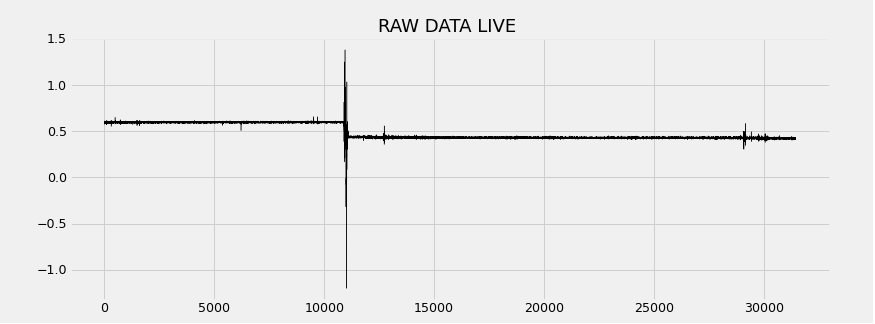

<IPython.core.display.Javascript object>


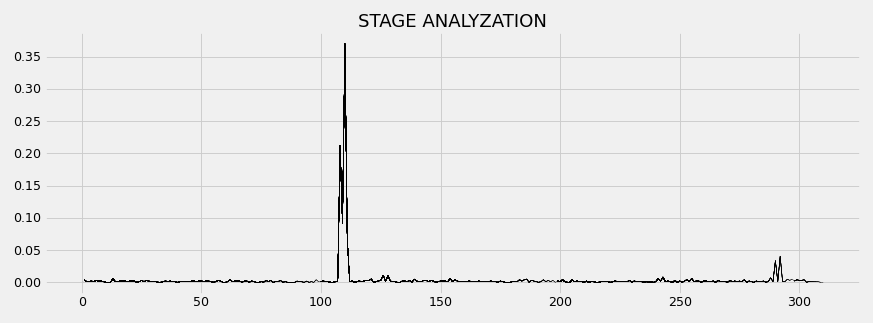

<bound method Figure.show of <Figure size 972x360 with 1 Axes>>

In [16]:
#plotting data
%matplotlib notebook
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (13.5,5))
ax = fig.add_subplot(111)
ax.title.set_text("RAW DATA LIVE ")
ax.hlines(0,0,1,color="k", linewidth=0.1)

fig2 = plt.figure(figsize = (13.5,5))
ax2 = fig2.add_subplot(111)
ax2.title.set_text("STAGE ANALYZATION")
ax2.hlines(0,0,1,color="k", linewidth=0.1)


fig.show()
fig2.show

In [ ]:
#flush serial input
ser1.flushInput()

#100 points to 1 point => 1 second 1 point
DATA3_100 = []

#A list to calculate baseline removal 
DATA3_BASELINE=[]

#A list to save the 90% data of the DATA3_100 list
DATA3_percentile_90 = []

#False means the stage hasn't change
#state1 = False
#state2 = False
N = 0
state = 0
statecount = 0
statechange = False


time_left = 50
time = []
#counter for differeniated data (dif_y3)
d3 = 2

#counter for x3 
count3 = 1

x3=[]#plotting x
dif_y3 =[]#plotting y
dif3_10 = []

count3_raw2 = 1#counter for clearing the list
count3_raw = 1#counter for appending data
raw3=[]#copying the raw data from the original data set, plotting raw y
x3_raw=[]#counts of x axis, plotting raw x

#baslineing the raw data
# polynomial_degree = 2 #only needed for Modpoly and IModPoly algorithm
# baseObj1 = BaselineRemoval(data_arryR)        
# y3_raw3 = baseObj1.IModPoly(polynomial_degree)

i = 0
#calcualte the baseline removal values 
while (len(DATA3_BASELINE) < 1000):
    data_raw3 = ser1.readline()
    data3 = data_raw3.decode().split()
    if len(data3) ==5 and isinstance(float(data3[4]),float):
        DATA3_BASELINE.append(float(data3[4]))
    i+=1
    if (len(DATA3_BASELINE) == 1000):
        polynomial_degree = 2 #only needed for Modpoly and IModPoly algorithm
        baseObj = BaselineRemoval(DATA3_BASELINE)        
        base_line = baseObj.IModPoly(polynomial_degree)
        removal = np.mean(DATA3_BASELINE)-np.mean(base_line)
        
#live streaming data and plotting
i=0

while True:
    data_raw3 = ser1.readline()
    data3 = data_raw3.decode()
    if len(data3.split())==5:#filter out abnormal data
        dataraw3 = data3.split()
    if isinstance(float(dataraw3[4]),float):
        x3_raw.append(count3_raw)
        raw3.append(float(dataraw3[4])-removal)
        count3_raw+=1
        count3_raw2+=1
        if count3_raw2 == 100:
            ax.plot(x3_raw,raw3,color = 'k',linewidth=0.5)
            fig.canvas.draw()
            count3_raw2 = 1
            count3_raw-=1
            raw3.clear()
            x3_raw.clear()
    
    if len(DATA3_100) < 100:# filling queue
            DATA3_100.append(float(dataraw3[4])-removal)
            i+=1
            
    elif len(DATA3_100) == 100:#find the 90% of the DATA3_100 and append it into DATA3_percentile_90
        DATA3_percentile_90.append(np.percentile(DATA3_100, 90))
        DATA3_100 = []
        
        if len(DATA3_percentile_90)>2:
            if count3%5 ==0:
                if count3%60==0:
                    time_left -= 1
                if statecount ==0:
                    time_left = 50
#                 current_time = get_current_time()
#                 sql = "INSERT INTO `washer_state` (`time`, `washer_id`, `state_id`, `user_id`, `left_time`) VALUES ('"+str(current_time)+"', '001009003', '"+str(state)+"', '','"+str(time_left)+"' ); " 
#                 CURSOR.execute(sql) 
#                 CONNECTION.commit()
            dif_y3.append(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2]))
            x3.append(count3)
            count3+=1
            
            ax2.plot(x3,dif_y3,color = 'k',linewidth=0.5)
            fig2.canvas.draw()
            
            if len(dif3_10)<10:
                dif3_10.append(abs(DATA3_percentile_90[d3-1]-DATA3_percentile_90[d3-3]))
            else:
                dif3_10.pop(0)
                dif3_10.append(abs(DATA3_percentile_90[d3-1]-DATA3_percentile_90[d3-3]))
            dif3_mean = np.mean(dif3_10)
            dif3_mid = np.percentile(dif3_10, 50)
            print("raw "+str(d3)+" d3-d3-2 "+str(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2]))+" mean "+str(dif3_mean)+" /"+str(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])/dif3_mean)+" - "+str(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])-dif3_mean)+str(d3)+" d3 "+ str(DATA3_percentile_90[d3])+" d3-1 "+str(DATA3_percentile_90[d3-1]))
                  
            if not statechange:
                if(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])/dif3_mean > 4 and DATA3_percentile_90[d3]>0.13 and DATA3_percentile_90[d3-1]<0.13) or ((abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])-dif3_mean) > 0.1 and DATA3_percentile_90[d3]<0.075 and DATA3_percentile_90[d3-1]>0.075) or ((abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])-dif3_mean) > 0.05 and DATA3_percentile_90[d3]<0.15 and DATA3_percentile_90[d3-1]>0.15) or ((abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])/dif3_mean) > 6 and DATA3_percentile_90[d3]<0.075 and DATA3_percentile_90[d3-1]>0.075): 
                    time.append(d3)
                    state += 1
                    ax2.vlines(d3-1,-0.4,0.4,color="red", linewidth=2)
                    fig2.canvas.draw()
                    print("HI")
                    if state ==5:
                        state = 1
                        statecount+=1
                    if statecount == 3:
                        statecount = 0
                        state = 0
                        time_left = 50
                    statechange = True
                    if state ==1 or state == 0:
                        if statecount>=1:
                            time_left = (time_left*60 - (time[len(time)-1]-time[len(time)-2])/0.09)/60
                            
#                         current_time = get_current_time()
#                         sql = "INSERT INTO `washer_state` (`time`, `washer_id`, `state_id`, `user_id`, `left_time`) VALUES ('"+str(current_time)+"', '001009003', '"+str(state)+"', '','"+str(time_left)+"' ); " 
#                         CURSOR.execute(sql) 
#                         CONNECTION.commit()
                        
                    else:
                        if state == 2:
                            time_left = (time_left*60 - (time[len(time)-1]-time[len(time)-2])/0.1547)/60
                        if state == 3:
                            time_left = (time_left*60 - (time[len(time)-1]-time[len(time)-2])/0.2016)/60
                        if state == 4:
                            time_left = (time_left*60 - (time[len(time)-1]-time[len(time)-2])/0.0369)/60

#                         current_time = get_current_time()
#                         sql = "INSERT INTO `washer_state` (`time`, `washer_id`, `state_id`, `user_id`, `left_time`) VALUES ('"+str(current_time)+"', '001009003', '"+str(state)+"', '','"+str(time_left)+"' ); " 
#                         CURSOR.execute(sql) 
#                         CONNECTION.commit()
            if statechange:
                N+=1
                if N == 3:
                    statechange = False
                    N = 0   
            
#             if not state3r:
#                 if abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])/dif3_mean > 4 and DATA3_percentile_90[d3]>0.13 and DATA3_percentile_90[d3-1]<0.13:# and DATA3_percentile_90[d3]>0.13 and DATA3_percentile_90[d3-1]<0.13 : #bang and rinse to wash
#                     print("RED "+str(d3)+" d3-d3-2 "+str(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2]))+" mean "+str(dif3_mean)+" "+str(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])/dif3_mean)+" d3 "+ str(DATA3_percentile_90[d3])+" d3-1 "+str(DATA3_percentile_90[d3-1]))
                    
# #                     state = 1
# #                     current_time = get_current_time()
# #                     sql = "INSERT INTO `washer_state` (`time`, `washer_id`, `state_id`, `user_id`, `left_time`) VALUES ('"+str(current_time)+"', '001009003', '"+str(state)+"', '','"+str(time_left)+"' ); " 
# #                     CURSOR.execute(sql) 
# #                     CONNECTION.commit()
                    
#                     ax2.vlines(d3-1,-0.4,0.4,color="red", linewidth=2)
#                     ax2.text(d3-1,0.5,"washing")
#                     fig.canvas.draw()
#                     state3r = True
#                     startr = time.time()
#             elif (time.time()-startr)>=2:
#                 state3r = False
                    
                
#             if not state3b:
#                 if (abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])-dif3_mean) > 0.1 and DATA3_percentile_90[d3]<0.075 and DATA3_percentile_90[d3-1]>0.075:#
#                     print("GREEN "+str(d3)+" d3-d3-2 "+str(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2]))+" mean "+str(dif3_mean)+" "+str(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])-dif3_mean)+" d3 "+ str(DATA3_percentile_90[d3])+" d3-1 "+str(DATA3_percentile_90[d3-1]))
                    
# #                     state = 2
# #                     current_time = get_current_time()
# #                     sql = "INSERT INTO `washer_state` (`time`, `washer_id`, `state_id`, `user_id`, `left_time`) VALUES ('"+str(current_time)+"', '001009003', '"+str(state)+"', '','"+str(time_left)+"' ); " 
# #                     CURSOR.execute(sql) 
# #                     CONNECTION.commit()
                    
#                     if not state3b:   
#                         ax2.vlines(d3-1,-0.4,0.4,color="green", linewidth=2)
#                         ax2.text(d3-1,0.5,"washing")
#                         fig2.canvas.draw()
#                         state3b = True
#                         startb = time.time()
#             elif time.time()-startb >= 2:
#                 state3b = False
                   
#             if not state3ac: 
#                 if (abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])-dif3_mean) > 0.05 and DATA3_percentile_90[d3]<0.15 and DATA3_percentile_90[d3-1]>0.15:
#                     print("AQUA "+str(d3)+" d3-d3-2 "+str(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2]))+" mean "+str(dif3_mean)+" "+str(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])/dif3_mean)+" d3 "+ str(DATA3_percentile_90[d3])+" d3-1 "+str(DATA3_percentile_90[d3-1]))
                    
# #                     state = 3
# #                     current_time = get_current_time()
# #                     sql = "INSERT INTO `washer_state` (`time`, `washer_id`, `state_id`, `user_id`, `left_time`) VALUES ('"+str(current_time)+"', '001009003', '"+str(state)+"', '','"+str(time_left)+"' ); " 
# #                     CURSOR.execute(sql) 
# #                     CONNECTION.commit()
                    
#                     if not state3ac: 
#                         ax2.vlines(d3-1,-0.4,0.4,color="aqua", linewidth=2)
#                         ax2.text(d3-1,0.45,"rinsing")
#                         fig2.canvas.draw()
#                         state3ac = True
#                         startac = time.time()
#             elif time.time()-startac >= 2:
#                     state3ac = False 
                    
#             if not state3d:
#                 if (abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])/dif3_mean) > 6 and DATA3_percentile_90[d3]<0.075 and DATA3_percentile_90[d3-1]>0.075:
#                     print("DARKORCHID "+str(d3)+" d3-d3-2 "+str(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2]))+" mean "+str(dif3_mean)+" "+str(abs(DATA3_percentile_90[d3]-DATA3_percentile_90[d3-2])/dif3_mean)+" d3 "+ str(DATA3_percentile_90[d3])+" d3-1 "+str(DATA3_percentile_90[d3-1]))
                    
# #                     state = 4
# #                     current_time = get_current_time()
# #                     sql = "INSERT INTO `washer_state` (`time`, `washer_id`, `state_id`, `user_id`, `left_time`) VALUES ('"+str(current_time)+"', '001009003', '"+str(state)+"', '','"+str(time_left)+"' ); " 
# #                     CURSOR.execute(sql) 
# #                     CONNECTION.commit()

#                     if not state3d: 
#                         ax2.vlines(d3-1,-0.4,0.4,color="darkorchid", linewidth=2)
#                         ax2.text(d3-1,0.4,"rinse spinning")
#                         fig2.canvas.draw()
#                         state3d = True
#                         startd = time.time()
#             elif time.time()-startd >= 2:
#                 state3d = False

            d3+=1
            
            if len(x3)==100:
                count3-=1
                d3-=1
                dif_y3.clear()
                x3.clear()
                
            plt.tight_layout()
            plt.show()

raw 2 d3-d3-2 0.0040000000000000036 mean 0.0019000000000000128 /2.1052631578947247 - 0.00209999999999999082 d3 0.605746204849648 d3-1 0.603846204849648
raw 3 d3-d3-2 0.0010000000000000009 mean 0.002950000000000008 /0.338983050847457 - -0.00195000000000000733 d3 0.604846204849648 d3-1 0.605746204849648
raw 4 d3-d3-2 0.0010000000000000009 mean 0.0023000000000000056 /0.4347826086956515 - -0.00130000000000000474 d3 0.606746204849648 d3-1 0.604846204849648
raw 5 d3-d3-2 0.0020000000000000018 mean 0.0019750000000000045 /1.0126582278480998 - 2.4999999999997247e-055 d3 0.602846204849648 d3-1 0.606746204849648
raw 6 d3-d3-2 0.0010000000000000009 mean 0.001980000000000004 /0.5050505050505045 - -0.0009800000000000036 d3 0.605746204849648 d3-1 0.602846204849648
raw 7 d3-d3-2 0.0029000000000000137 mean 0.0018166666666666702 /1.5963302752293622 - 0.00108333333333334357 d3 0.605746204849648 d3-1 0.605746204849648
raw 8 d3-d3-2 0.0019000000000000128 mean 0.0019714285714285762 /0.9637681159420332 - -7.

raw 57 d3-d3-2 0.0010000000000000009 mean 0.001529999999999998 /0.6535947712418315 - -0.00052999999999999757 d3 0.605746204849648 d3-1 0.603746204849648
raw 58 d3-d3-2 0.0030000000000000027 mean 0.001429999999999998 /2.097902097902103 - 0.001570000000000004858 d3 0.606746204849648 d3-1 0.605746204849648
raw 59 d3-d3-2 0.0020000000000000018 mean 0.001529999999999998 /1.307189542483663 - 0.0004700000000000038359 d3 0.603746204849648 d3-1 0.606746204849648
raw 60 d3-d3-2 0.0 mean 0.0016299999999999982 /0.0 - -0.001629999999999998260 d3 0.606746204849648 d3-1 0.603746204849648
raw 61 d3-d3-2 0.0 mean 0.001429999999999998 /0.0 - -0.00142999999999999861 d3 0.603746204849648 d3-1 0.606746204849648
raw 62 d3-d3-2 0.0010000000000000009 mean 0.0012199999999999989 /0.8196721311475424 - -0.0002199999999999979762 d3 0.605746204849648 d3-1 0.603746204849648
raw 63 d3-d3-2 0.0040000000000000036 mean 0.00121 /3.3057851239669453 - 0.002790000000000003463 d3 0.607746204849648 d3-1 0.605746204849648
raw 

raw 113 d3-d3-2 0.0010999999999999899 mean 0.07435000000000003 /0.01479488903833207 - -0.07325000000000004113 d3 0.446746204849648 d3-1 0.446746204849648
raw 114 d3-d3-2 0.0020000000000000018 mean 0.07436000000000002 /0.026896180742334606 - -0.07236000000000002114 d3 0.444746204849648 d3-1 0.446746204849648
raw 115 d3-d3-2 9.999999999998899e-05 mean 0.07447000000000002 /0.0013428226131326569 - -0.07437000000000003115 d3 0.446846204849648 d3-1 0.444746204849648
raw 116 d3-d3-2 0.0009999999999998899 mean 0.07447000000000002 /0.013428226131326569 - -0.07347000000000013116 d3 0.4437462048496481 d3-1 0.446846204849648
raw 117 d3-d3-2 0.0020999999999999908 mean 0.07456000000000002 /0.028165236051502018 - -0.07246000000000002117 d3 0.444746204849648 d3-1 0.4437462048496481
raw 118 d3-d3-2 0.0009999999999998899 mean 0.07468000000000001 /0.013390465988214913 - -0.07368000000000012118 d3 0.444746204849648 d3-1 0.444746204849648
raw 119 d3-d3-2 0.0019999999999998908 mean 0.07468 /0.02678093197643

raw 167 d3-d3-2 0.0020000000000000018 mean 0.0015399999999999969 /1.2987012987013025 - 0.0004600000000000049167 d3 0.4387462048496481 d3-1 0.4377462048496481
raw 168 d3-d3-2 0.0010999999999999899 mean 0.0013399999999999968 /0.8208955223880541 - -0.00024000000000000692168 d3 0.4388462048496481 d3-1 0.4387462048496481
raw 169 d3-d3-2 0.0010000000000000009 mean 0.0012499999999999955 /0.8000000000000036 - -0.0002499999999999946169 d3 0.4377462048496481 d3-1 0.4388462048496481
raw 170 d3-d3-2 0.0010000000000000009 mean 0.0012499999999999955 /0.8000000000000036 - -0.0002499999999999946170 d3 0.4398462048496481 d3-1 0.4377462048496481
raw 171 d3-d3-2 0.0010000000000000009 mean 0.0012399999999999967 /0.8064516129032286 - -0.00023999999999999586171 d3 0.4387462048496481 d3-1 0.4398462048496481
raw 172 d3-d3-2 0.0020999999999999908 mean 0.0012299999999999978 /1.7073170731707272 - 0.000869999999999993172 d3 0.4377462048496481 d3-1 0.4387462048496481
raw 173 d3-d3-2 0.0010000000000000009 mean 0.00

raw 220 d3-d3-2 0.0010999999999999899 mean 0.000660000000000005 /1.6666666666666388 - 0.0004399999999999849220 d3 0.4357462048496481 d3-1 0.4367462048496481
raw 221 d3-d3-2 0.0010000000000000009 mean 0.0006700000000000039 /1.4925373134328284 - 0.00032999999999999696221 d3 0.4357462048496481 d3-1 0.4357462048496481
raw 222 d3-d3-2 0.0 mean 0.000770000000000004 /0.0 - -0.000770000000000004222 d3 0.4357462048496481 d3-1 0.4357462048496481
raw 223 d3-d3-2 0.0010000000000000009 mean 0.0005800000000000027 /1.7241379310344762 - 0.0004199999999999982223 d3 0.4347462048496481 d3-1 0.4357462048496481
raw 224 d3-d3-2 0.0020999999999999908 mean 0.0006800000000000029 /3.0882352941176205 - 0.001419999999999988224 d3 0.4378462048496481 d3-1 0.4347462048496481
raw 225 d3-d3-2 0.0010000000000000009 mean 0.0007900000000000019 /1.2658227848101247 - 0.00020999999999999903225 d3 0.4357462048496481 d3-1 0.4378462048496481
raw 226 d3-d3-2 0.0010999999999999899 mean 0.0008000000000000007 /1.3749999999999862 -

raw 275 d3-d3-2 0.0010000000000000009 mean 0.0014000000000000013 /0.7142857142857143 - -0.0004000000000000004275 d3 0.4367462048496481 d3-1 0.4377462048496481
raw 276 d3-d3-2 0.0019000000000000128 mean 0.0013000000000000012 /1.46153846153847 - 0.0006000000000000115276 d3 0.4358462048496481 d3-1 0.4367462048496481
raw 277 d3-d3-2 0.0010000000000000009 mean 0.0014900000000000024 /0.6711409395973149 - -0.0004900000000000015277 d3 0.4377462048496481 d3-1 0.4358462048496481
raw 278 d3-d3-2 0.0039000000000000146 mean 0.0012900000000000023 /3.023255813953494 - 0.0026100000000000125278 d3 0.4397462048496481 d3-1 0.4377462048496481
raw 279 d3-d3-2 0.0 mean 0.0015800000000000037 /0.0 - -0.0015800000000000037279 d3 0.4377462048496481 d3-1 0.4397462048496481
raw 280 d3-d3-2 0.0020000000000000018 mean 0.0014800000000000034 /1.3513513513513493 - 0.0005199999999999983280 d3 0.4377462048496481 d3-1 0.4377462048496481
raw 281 d3-d3-2 0.0010999999999999899 mean 0.0015700000000000048 /0.7006369426751506 

In [ ]:
while True:
    data_raw3 = ser1.readline()
    data3 = data_raw3.decode()
    if len(data3.split())==5:#filter out abnormal data
        dataraw3 = data3.split()
        print(dataraw3[4])

In [ ]:

x3_raw=[]
raw3 = []
count3_raw = 1
count3_raw2 = 1
polynomial_degree = 2 #only needed for Modpoly and IModPoly algorithm
baseObj1 = BaselineRemoval(data_arryR)        
y3_raw3 = baseObj1.IModPoly(polynomial_degree)
while True:
    x3_raw.append(count3_raw)
    raw3.append(float(y3_raw3[120000+count3_raw-1]))
    count3_raw+=1
    count3_raw2 +=1
    if count3_raw2 == 100:
        ax.plot(x3_raw,raw3,color = 'k',linewidth=0.5)
        fig.canvas.draw()
        plt.clf()
        count3_raw2 = 1
        count3_raw-=1
        raw3.clear()
        x3_raw.clear()

In [ ]:
#差勁資料庫
current_time = get_current_time()
sql = "INSERT INTO `washer_state` (`time`, `washer_id`, `state_id`, `user_id`, `left_time`) VALUES ('"+str(current_time)+"', '001009003', '裝置狀態(0~4)', '','"+str("剩餘時間")+"' ); " 
CURSOR.execute(sql) 
CONNECTION.commit()

In [ ]:
import random
from itertools import count
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.style.use('fivethirtyeight')

x_values = []
y_values = []

index = count()


def animate(i):
    x_values.append(next(index))
    y_values.append(random.randint(0, 5))
    plt.cla()
    plt.plot(x_values, y_values)


ani = FuncAnimation(plt.gcf(), animate, 1000)


plt.tight_layout()
plt.show()

In [ ]:
import time
from matplotlib import pyplot as plt
import numpy as np

def live_update_demo(blit = False):
    x = np.linspace(0,50., num=100)
    X,Y = np.meshgrid(x,x)
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)

    img = ax1.imshow(X, vmin=-1, vmax=1, interpolation="None", cmap="RdBu")


    line, = ax2.plot([], lw=3)
    text = ax2.text(0.8,0.5, "")

    ax2.set_xlim(x.min(), x.max())
    ax2.set_ylim([-1.1, 1.1])

    fig.canvas.draw()   # note that the first draw comes before setting data 


    if blit:
        # cache the background
        axbackground = fig.canvas.copy_from_bbox(ax1.bbox)
        ax2background = fig.canvas.copy_from_bbox(ax2.bbox)

    plt.show(block=False)


    t_start = time.time()
    k=0.

    for i in np.arange(100000):
        img.set_data(np.sin(X/3.+k)*np.cos(Y/3.+k))
        line.set_data(x, np.sin(x/3.+k))
        tx = 'Mean Frame Rate:\n {fps:.3f}FPS'.format(fps= ((i+1) / (time.time() - t_start)) ) 
        text.set_text(tx)
        #print tx
        k+=0.11
        if blit:
            # restore background
            fig.canvas.restore_region(axbackground)
            fig.canvas.restore_region(ax2background)

            # redraw just the points
            ax1.draw_artist(img)
            ax2.draw_artist(line)
            ax2.draw_artist(text)

            # fill in the axes rectangle
            fig.canvas.blit(ax1.bbox)
            fig.canvas.blit(ax2.bbox)

            # in this post http://bastibe.de/2013-05-30-speeding-up-matplotlib.html
            # it is mentionned that blit causes strong memory leakage. 
            # however, I did not observe that.

        else:
            # redraw everything
            fig.canvas.draw()

        fig.canvas.flush_events()
        #alternatively you could use
        #plt.pause(0.000000000001) 
        # however plt.pause calls canvas.draw(), as can be read here:
        #http://bastibe.de/2013-05-30-speeding-up-matplotlib.html


live_update_demo(True)   # 175 fps


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 2 * np.pi, 100)

fig, ax = plt.subplots()

# animated=True tells matplotlib to only draw the artist when we
# explicitly request it
(ln,) = ax.plot(x, np.sin(x), animated=True)

# make sure the window is raised, but the script keeps going
plt.show(block=False)
fig.canvas.draw()
# stop to admire our empty window axes and ensure it is rendered at
# least once.
#
# We need to fully draw the figure at its final size on the screen
# before we continue on so that :
#  a) we have the correctly sized and drawn background to grab
#  b) we have a cached renderer so that ``ax.draw_artist`` works
# so we spin the event loop to let the backend process any pending operations
plt.pause(0.1)

# get copy of entire figure (everything inside fig.bbox) sans animated artist
bg = fig.canvas.copy_from_bbox(fig.bbox)
# draw the animated artist, this uses a cached renderer
ax.draw_artist(ln)
# show the result to the screen, this pushes the updated RGBA buffer from the
# renderer to the GUI framework so you can see it
fig.canvas.blit(fig.bbox)

for j in range(100000):
    # reset the background back in the canvas state, screen unchanged
    fig.canvas.restore_region(bg)
    # update the artist, neither the canvas state nor the screen have changed
    ln.set_ydata(np.sin(x + (j / 100) * np.pi))
    # re-render the artist, updating the canvas state, but not the screen
    ax.draw_artist(ln)
    # copy the image to the GUI state, but screen might not be changed yet
    fig.canvas.blit(fig.bbox)
    # flush any pending GUI events, re-painting the screen if needed
    fig.canvas.flush_events()
    # you can put a pause in if you want to slow things down
    # plt.pause(.1)